In [1]:
import numpy as np
import pandas as pd
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.model_selection import GridSearchCV
import seaborn as sns

In [2]:
training_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/landsat7_train.csv')
testing_data = pd.read_csv('/kaggle/input/mekong-training-testing-set/landsat7_test.csv')

In [3]:
# Change the type into date time
def into_datetime(df):
    df['date'] = pd.to_datetime(df['date'])
    df['month'] = df['date'].dt.month
    df['year'] = df['date'].dt.year

In [4]:
into_datetime(training_data)
into_datetime(testing_data)

In [5]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AWEInsh    56 non-null     float64       
 1   AWEIsh     56 non-null     float64       
 2   MNDWI      56 non-null     float64       
 3   NDWI       56 non-null     float64       
 4   SR_B1      56 non-null     float64       
 5   SR_B2      56 non-null     float64       
 6   SR_B3      56 non-null     float64       
 7   SR_B4      56 non-null     float64       
 8   SR_B5      56 non-null     float64       
 9   SR_B7      56 non-null     float64       
 10  ST_B6      56 non-null     float64       
 11  WI1        56 non-null     float64       
 12  WI2        56 non-null     float64       
 13  date       56 non-null     datetime64[ns]
 14  pivot      56 non-null     int64         
 15  reducer    56 non-null     object        
 16  source     56 non-null     object        
 17 

In [6]:
testing_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 11 entries, 0 to 10
Data columns (total 38 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   AWEInsh    11 non-null     float64       
 1   AWEIsh     11 non-null     float64       
 2   MNDWI      11 non-null     float64       
 3   NDWI       11 non-null     float64       
 4   SR_B1      11 non-null     float64       
 5   SR_B2      11 non-null     float64       
 6   SR_B3      11 non-null     float64       
 7   SR_B4      11 non-null     float64       
 8   SR_B5      11 non-null     float64       
 9   SR_B7      11 non-null     float64       
 10  ST_B6      11 non-null     float64       
 11  WI1        11 non-null     float64       
 12  WI2        11 non-null     float64       
 13  date       11 non-null     datetime64[ns]
 14  pivot      11 non-null     int64         
 15  reducer    11 non-null     object        
 16  source     11 non-null     object        
 17 

In [7]:
features = [ 'SR_B4', 'SR_B5', 'SR_B7',
    'ST_B6', 'WI1', 'WI2', 'month', 'year', 'Latitude', 'Longitude'
]

In [8]:
target = 'max'

In [9]:
# Split data
X_train = training_data[features]
y_train = training_data[target]
X_test = testing_data[features]
y_test = testing_data[target]

In [10]:
# Apply log-transform to target (use log1p to handle zeros)
#y_train_log = np.log1p(training_data[target])

In [11]:
param_grid = {
    'n_estimators': [100, 200],            # Reduce number of trees
    'max_depth': [5, 10],                  # Prevent very deep trees
    'min_samples_split': [5, 10],          # More conservative splits
    'min_samples_leaf': [4, 6, 8],         # Leaf must have enough samples
    'max_features': ['sqrt', 0.3]          # Reduce feature randomness
}

In [12]:
# Initialize and run GridSearchCV
rf = RandomForestRegressor(random_state=42)
grid_search = GridSearchCV(estimator=rf,
                           param_grid=param_grid,
                           cv=5,
                           scoring='neg_mean_squared_error',
                           n_jobs=-1,
                           verbose=2)

In [13]:
grid_search.fit(X_train, y_train)

Fitting 5 folds for each of 48 candidates, totalling 240 fits


GridSearchCV(cv=5, estimator=RandomForestRegressor(random_state=42), n_jobs=-1,
             param_grid={'max_depth': [5, 10], 'max_features': ['sqrt', 0.3],
                         'min_samples_leaf': [4, 6, 8],
                         'min_samples_split': [5, 10],
                         'n_estimators': [100, 200]},
             scoring='neg_mean_squared_error', verbose=2)

In [14]:
# Best model
best_model = grid_search.best_estimator_

In [15]:
# Predict (inverse log1p → expm1)
y_pred = best_model.predict(X_test)

In [16]:
def wmape(y_true, y_pred):
    return 100 * np.sum(np.abs(y_true - y_pred)) / (np.sum(np.abs(y_true)) + 1e-8)

def evaluate_model(model, X, y, dataset_name=""):
    y_pred = model.predict(X)
    rmse = mean_squared_error(y, y_pred, squared=False)
    r2 = r2_score(y, y_pred)
    mae = mean_absolute_error(y, y_pred)
    wmape_score = wmape(y, y_pred)

    print(f"\n📊 Evaluation on {dataset_name} Set:")
    print(f"• RMSE  : {rmse:.4f}")
    print(f"• R²    : {r2:.4f}")
    print(f"• MAE   : {mae:.4f}")
    print(f"• WMAPE : {wmape_score:.2f}%")

In [17]:
# Evaluate on both sets
evaluate_model(best_model, X_train, y_train, "Training")



📊 Evaluation on Training Set:
• RMSE  : 4.3985
• R²    : 0.6730
• MAE   : 3.4515
• WMAPE : 32.61%


In [18]:
evaluate_model(best_model, X_test, y_test, "Testing")


📊 Evaluation on Testing Set:
• RMSE  : 3.6382
• R²    : 0.7372
• MAE   : 2.9465
• WMAPE : 39.72%


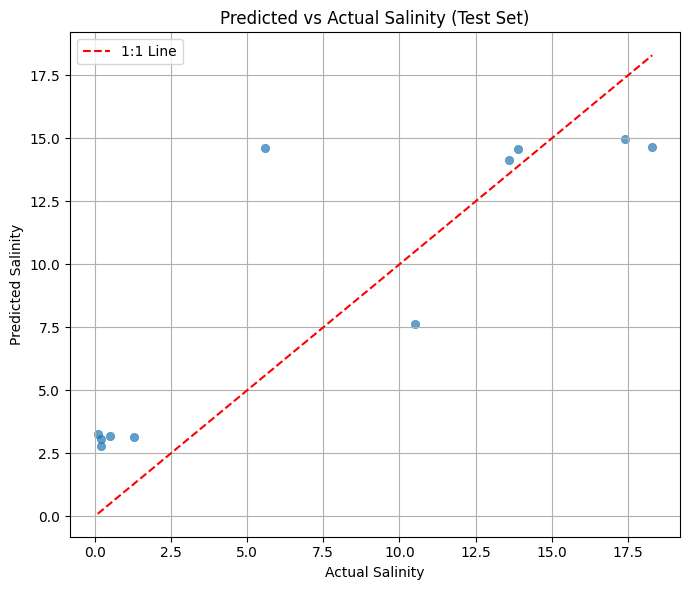

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(7, 6))
sns.scatterplot(x=y_test, y=y_pred, alpha=0.7, edgecolor=None)

# Add 1:1 reference line
min_val = min(y_test.min(), y_pred.min())
max_val = max(y_test.max(), y_pred.max())
plt.plot([min_val, max_val], [min_val, max_val], '--', color='red', label='1:1 Line')

plt.xlabel('Actual Salinity')
plt.ylabel('Predicted Salinity')
plt.title('Predicted vs Actual Salinity (Test Set)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()